## Split train dataset into train and validation set

In [1]:
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
from scipy.io import loadmat

import glob

import shutil

from keras.preprocessing import image
from keras.models import Sequential, Model, load_model 
from keras.layers import Input, Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.applications import VGG16
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD, Adadelta

from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import itertools

C:\Users\SUDEEP\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Train model

### Create batches

In [2]:
def get_batches(dirname, gen = image.ImageDataGenerator(), shuffle=True, target_size=(48,48), 
                batch_size=8):        
    batch_gen = gen.flow_from_directory(dirname, target_size=target_size, 
            class_mode='categorical', shuffle=shuffle, batch_size=batch_size)    
    num_batch = len(batch_gen)
    return batch_gen, num_batch

## VGG16 Model - untrained

In [4]:
datagen = image.ImageDataGenerator(rescale=1./255)

In [5]:
batch_size = 128
nb_classes = 11

train_batches, num_train_batches = get_batches('./data/train_32x32',  
                                               gen=datagen,
                                               batch_size=batch_size,
                                               target_size=(48,48))

valid_batches, num_valid_batches = get_batches('./data/valid_32x32',
                                               gen=datagen,
                                               shuffle=False,                                               
                                               batch_size=batch_size * 2,
                                               target_size=(48,48))

Found 66607 images belonging to 11 classes.
Found 16652 images belonging to 11 classes.


In [6]:
# test_batches, num_test_batches = get_batches('./data/test', gen=datagen,
#                                                 shuffle=False, batch_size=batch_size * 2)

In [7]:
train_labels = to_categorical(train_batches.classes)
valid_labels = to_categorical(valid_batches.classes)

In [8]:
vgg_model = VGG16(include_top=False, weights=None, input_shape=(48, 48, 3))
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [9]:
#Adding custom Layers 
# x = vgg_model_untrained1.output
# x = Flatten()(x)
# x = Dense(4096, activation="relu")(x)
# # x = Dropout(0.5)(x)
# x = Dense(4096, activation="relu")(x)
# predictions = Dense(10, activation="softmax")(x)

# creating the final model 
# vgg_model_untrained2 = Model(input = vgg_model_untrained1.input, output = predictions)

# vgg_model_untrained2.summary()

input = Input(shape=(48,48,3), name = 'image_input')

#Use the generated model
output_vgg_model = vgg_model(input)

#Add the fully-connected layers
x = Flatten(name='flatten')(output_vgg_model)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.25, name="dropout1")(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.25, name="dropout2")(x)
x = Dense(512, activation='relu', name='fc3')(x)
x = Dropout(0.25, name="dropout3")(x)
output = Dense(nb_classes, activation="softmax", name="output")(x)

model = Model(inputs=input, outputs=output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout1 (Dropout)           (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout2 (Dropout)           (None, 512)               0         
__________

In [10]:
# optimizer = SGD(lr=3.0, decay=1e-6, momentum=0.9, nesterov=True)
# optimizer = Adam(lr=1.0)
optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16_untrained.hdf5', 
                               verbose=1, save_best_only=True)

In [11]:
model.fit_generator(train_batches, steps_per_epoch = num_train_batches,
                    epochs=20, verbose=1, validation_data=valid_batches, 
                    validation_steps=num_valid_batches, callbacks=[checkpointer])

Epoch 1/20
521/521 [==============================] - 59s 114ms/step - loss: 2.2761 - acc: 0.1943 - val_loss: 2.0658 - val_acc: 0.2797

Epoch 00001: val_loss improved from inf to 2.06584, saving model to saved_models/weights.best.VGG16_untrained.hdf5
Epoch 2/20
521/521 [==============================] - 56s 107ms/step - loss: 1.3402 - acc: 0.5558 - val_loss: 0.7063 - val_acc: 0.7959

Epoch 00002: val_loss improved from 2.06584 to 0.70631, saving model to saved_models/weights.best.VGG16_untrained.hdf5
Epoch 3/20
521/521 [==============================] - 56s 107ms/step - loss: 0.4590 - acc: 0.8691 - val_loss: 0.4007 - val_acc: 0.8857

Epoch 00003: val_loss improved from 0.70631 to 0.40069, saving model to saved_models/weights.best.VGG16_untrained.hdf5
Epoch 4/20
521/521 [==============================] - 56s 108ms/step - loss: 0.2924 - acc: 0.9186 - val_loss: 0.2997 - val_acc: 0.9151

Epoch 00004: val_loss improved from 0.40069 to 0.29971, saving model to saved_models/weights.best.VGG16

## VGG16 Model - pre-trained

In [12]:
datagen = image.ImageDataGenerator(rescale=1./255)

In [13]:
batch_size = 128
nb_classes = 11

train_batches, num_train_batches = get_batches('./data/train_32x32',  
                                               gen=datagen,
                                               batch_size=batch_size,
                                               target_size=(48,48))

valid_batches, num_valid_batches = get_batches('./data/valid_32x32',
                                               gen=datagen,
                                               shuffle=False,                                               
                                               batch_size=batch_size * 2,
                                               target_size=(48,48))

Found 66607 images belonging to 11 classes.
Found 16652 images belonging to 11 classes.


In [14]:
# test_batches, num_test_batches = get_batches('./data/test', gen=datagen,
#                                                 shuffle=False, batch_size=batch_size * 2)

In [15]:
train_labels = to_categorical(train_batches.classes)
valid_labels = to_categorical(valid_batches.classes)

In [16]:
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(48, 48, 3))
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [17]:
for layer in vgg_model.layers:
     layer.trainable = False

In [18]:
input = Input(shape=(48,48,3), name = 'image_input')

#Use the generated model
output_vgg_model = vgg_model(input)

#Add the fully-connected layers
x = Flatten(name='flatten')(output_vgg_model)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.25, name="dropout1")(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.25, name="dropout2")(x)
x = Dense(512, activation='relu', name='fc3')(x)
x = Dropout(0.25, name="dropout3")(x)
output = Dense(nb_classes, activation="softmax", name="output")(x)

model = Model(inputs=input, outputs=output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout1 (Dropout)           (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout2 (Dropout)           (None, 512)               0         
__________

In [19]:
# optimizer = SGD(lr=3.0, decay=1e-6, momentum=0.9, nesterov=True)
# optimizer = Adam(lr=1.0)
optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16_pretrained.hdf5', 
                               verbose=1, save_best_only=True)

In [20]:
model.fit_generator(train_batches, steps_per_epoch = num_train_batches,
                    epochs=20, verbose=1, validation_data=valid_batches, 
                    validation_steps=num_valid_batches, callbacks=[checkpointer])

Epoch 1/20
521/521 [==============================] - 23s 44ms/step - loss: 1.6150 - acc: 0.4426 - val_loss: 1.3394 - val_acc: 0.5465

Epoch 00001: val_loss improved from inf to 1.33944, saving model to saved_models/weights.best.VGG16_pretrained.hdf5
Epoch 2/20
521/521 [==============================] - 22s 43ms/step - loss: 1.3299 - acc: 0.5477 - val_loss: 1.2411 - val_acc: 0.5755

Epoch 00002: val_loss improved from 1.33944 to 1.24108, saving model to saved_models/weights.best.VGG16_pretrained.hdf5
Epoch 3/20
521/521 [==============================] - 22s 42ms/step - loss: 1.2391 - acc: 0.5794 - val_loss: 1.1990 - val_acc: 0.5929

Epoch 00003: val_loss improved from 1.24108 to 1.19903, saving model to saved_models/weights.best.VGG16_pretrained.hdf5
Epoch 4/20
521/521 [==============================] - 22s 42ms/step - loss: 1.1885 - acc: 0.5990 - val_loss: 1.1431 - val_acc: 0.6157

Epoch 00004: val_loss improved from 1.19903 to 1.14314, saving model to saved_models/weights.best.VGG16_

## Custom Model

In [3]:
datagen = image.ImageDataGenerator(rescale=1./255)

In [22]:
batch_size = 128
nb_classes = 11

train_batches, num_train_batches = get_batches('./data/train_32x32',  
                                               gen=datagen,
                                               batch_size=batch_size,
                                               target_size=(32,32))

valid_batches, num_valid_batches = get_batches('./data/valid_32x32',
                                               gen=datagen,
                                               shuffle=False,                                               
                                               batch_size=batch_size * 2,
                                               target_size=(32,32))

Found 66607 images belonging to 11 classes.
Found 16652 images belonging to 11 classes.


In [23]:
# test_batches, num_test_batches = get_batches('./data/test', gen=datagen,
#                                                 shuffle=False, batch_size=batch_size * 2)

In [24]:
train_labels = to_categorical(train_batches.classes)
valid_labels = to_categorical(valid_batches.classes)

In [25]:
model = Sequential()

#WITHOUT batch normalization
# model.add(Convolution2D(32, 3, 3, border_mode='same',
#                         input_shape=(32, 32, 3)))
# model.add(Activation('relu'))
# model.add(Convolution2D(32, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

# model.add(Convolution2D(64, 3, 3, border_mode='same'))
# model.add(Activation('relu'))
# model.add(Convolution2D(64, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(nb_classes))
# model.add(Activation('softmax'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

In [26]:
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
# adam = Adam(lr=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.custom_model.hdf5', 
                               verbose=1, save_best_only=True)

In [27]:
# model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_data=(X_test, y_test))
# score = model.evaluate(X_test, y_test, verbose=0)

# print('loss:', score[0])
# print('Test accuracy:', score[1])

#Test score: 0.332611555633
#Test accuracy: 0.904732636755

model.fit_generator(train_batches, steps_per_epoch = num_train_batches,
                    epochs=20, verbose=1, validation_data=valid_batches, 
                    validation_steps=num_valid_batches, callbacks=[checkpointer])

Epoch 1/20
521/521 [==============================] - 20s 39ms/step - loss: 2.3292 - acc: 0.1731 - val_loss: 2.2529 - val_acc: 0.2182

Epoch 00001: val_loss improved from inf to 2.25294, saving model to saved_models/weights.best.custom_model.hdf5
Epoch 2/20
521/521 [==============================] - 20s 38ms/step - loss: 1.8973 - acc: 0.3527 - val_loss: 1.1383 - val_acc: 0.6579

Epoch 00002: val_loss improved from 2.25294 to 1.13835, saving model to saved_models/weights.best.custom_model.hdf5
Epoch 3/20
521/521 [==============================] - 20s 38ms/step - loss: 0.8142 - acc: 0.7436 - val_loss: 0.5151 - val_acc: 0.8468

Epoch 00003: val_loss improved from 1.13835 to 0.51512, saving model to saved_models/weights.best.custom_model.hdf5
Epoch 4/20
521/521 [==============================] - 20s 38ms/step - loss: 0.5555 - acc: 0.8306 - val_loss: 0.4001 - val_acc: 0.8811

Epoch 00004: val_loss improved from 0.51512 to 0.40014, saving model to saved_models/weights.best.custom_model.hdf5


## Test Models

### Custom Model

In [11]:
model = load_model('saved_models/weights.best.custom_model.hdf5')

In [12]:
datagen = image.ImageDataGenerator(rescale=1./255)
batch_size = 128
test_batches, num_test_batches = get_batches('./data/test_32x32',
                                               gen=datagen,
                                               shuffle=False,                                               
                                               batch_size=batch_size * 2,
                                               target_size=(32,32))

Found 39099 images belonging to 11 classes.


In [13]:
num_test_batches

153

In [14]:
test_classes = test_batches.classes
test_classes

array([ 0,  0,  0, ..., 10, 10, 10], dtype=int32)

In [15]:
test_labels = to_categorical(test_batches.classes)

In [16]:
test_labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
preds = model.predict_generator(test_batches, verbose=1)

153/153 [==============================] - 10s 63ms/step


In [18]:
preds.shape

(39099, 11)

In [19]:
pred_labels = np.argmax(preds,axis=1)

In [20]:
pred_labels

array([ 0,  0,  0, ..., 10, 10, 10])

In [21]:
test_score = model.evaluate_generator(test_batches)

In [22]:
test_score

[0.19421822146475337, 0.9484385790481948]

In [23]:
cm = confusion_matrix(test_classes, pred_labels)

In [24]:
cm.shape

(11, 11)

In [25]:
cm

array([[ 1607,    16,    12,     9,     6,     9,    41,     5,    20,
           16,     3],
       [   22,  4864,    29,    26,    66,    10,     9,    54,     9,
            4,     6],
       [    5,    20,  3952,    59,    25,    10,    10,    40,    11,
           15,     2],
       [    7,    33,    23,  2633,    10,    77,    16,     6,    27,
           50,     0],
       [    5,    44,    20,    17,  2386,    12,     7,     6,     7,
           15,     4],
       [    6,    12,    12,    36,    14,  2244,    32,     2,    17,
            8,     1],
       [   19,    19,     9,    18,    17,    44,  1807,     2,    29,
           11,     2],
       [    3,    71,    27,    18,     3,     8,     2,  1883,     1,
            3,     0],
       [   12,    12,    10,    28,     7,    38,    66,     2,  1466,
           18,     1],
       [   28,    14,    38,    16,     7,    27,     9,     7,    19,
         1428,     2],
       [   59,    79,    10,    13,    35,    23,    14,    

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 1607    16    12     9     6     9    41     5    20    16     3]
 [   22  4864    29    26    66    10     9    54     9     4     6]
 [    5    20  3952    59    25    10    10    40    11    15     2]
 [    7    33    23  2633    10    77    16     6    27    50     0]
 [    5    44    20    17  2386    12     7     6     7    15     4]
 [    6    12    12    36    14  2244    32     2    17     8     1]
 [   19    19     9    18    17    44  1807     2    29    11     2]
 [    3    71    27    18     3     8     2  1883     1     3     0]
 [   12    12    10    28     7    38    66     2  1466    18     1]
 [   28    14    38    16     7    27     9     7    19  1428     2]
 [   59    79    10    13    35    23    14     5     7     9 12813]]


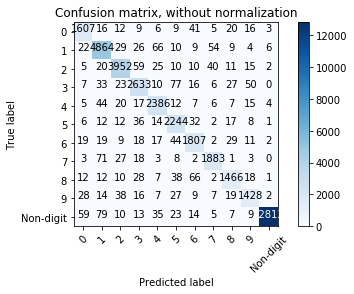

In [31]:
# Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['0','1','2','3','4','5','6','7','8','9','Non-digit'],
                      title='Confusion matrix, without normalization')

plt.show()

In [36]:
len(pred_labels[pred_labels == 5])

2502